In [73]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train = pd.read_csv('data/challenge3_train.csv', index_col='id')
test = pd.read_csv('data/challenge3_test.csv', index_col='id')
data = pd.concat([train, test])
print(f'train: {train.shape} | test: {test.shape}, all: {data.shape}')
train.head(2)

train: (50000, 33) | test: (50000, 32), all: (100000, 33)


,id,target,f0,f1,f2,f3,f4,f5,f6,f7,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0,1,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,1,0,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021


In [3]:
data = data.drop(['id', 'target'], axis=1)

In [70]:
# Generate reports
#pandas_profiling.ProfileReport(train, minimal=False).to_file('train_report.html')
#pandas_profiling.ProfileReport(test, minimal=False).to_file('test_report_small.html')
#pandas_profiling.ProfileReport(data, minimal=True).to_file('data_report.html')


# Report for 1/0 class
#pandas_profiling.ProfileReport(train[train['target'] == 1], minimal=False).to_file('train_1_report.html')
#pandas_profiling.ProfileReport(train[train['target'] == 0], minimal=False).to_file('train_0_report.html')


### Comparing train and test data: 

From reports we see f13 has different data distribution, however this is just because how the graph was made.

High corelevance with f10 and f14 - because they both have a lot of 0 values.

f10 possibly have high values that are noise. 

Categorical:

f5: M, F

f15: A, B, C

f20: A-Z

### Features:


binary: f0, f26

nominal: f5, f15, f12, f28

oridnal: f1, f2, f3, f6, f9, f11, f13, f17, f18, f19, f20, f21, f23, f24, f25, f27, f29

real: f7, f8, f16, f22, f30

int: f4, f10, f14

f11: [-1-11], probably describes month, where -1 is noise. 

f13: [-6-98], probably describes age, where <0 is noise.

f20: A-C, alphabet. So can be considered ordinal

## Compare 1/0 target class
#### 1 target:
- correlations (which are not present in other target): 
    - f21-f6 (very high). f21: 1-5, uniform distributiuon (target 0 is more normal-like). f6: 0-5, bit skewed to the right uniform dist. 
    - f25-f6 f25: uniform-ish except 0. 
    - f26-f4. f26: boolean, many 1. f4: real, lower mean, std
#### 0 target:
- correlations:
    - f26-f0. f26: bool, more are false than target 1. f0: bool
    - f26-f6. f6: 0-5, 4 most common, higher mean than t1. 




In [89]:
features_bin = ['f0', 'f26']
features_nom_low = ['f5', 'f15'] # nominal low cardinality (<=3)
features_nom_high = ['f28', 'f20'] # >= 26
features_ordinal_low = ['f1', 'f2', 'f3', 'f6', 'f9', 'f11', 'f13', 'f17', 'f18', 'f19', 'f21', 'f23', 'f24', 'f25', 'f27', 'f29']
features_ord_high = ['f4', 'f10', 'f14']
features_real = ['f7', 'f8', 'f16', 'f22', 'f30']


Percentage of feature values being NaN


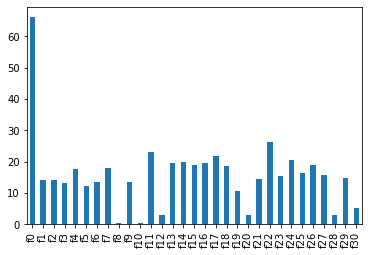

In [20]:
print('Percentage of feature values being NaN')
nans = data.isna().sum().map(lambda x: x / len(data) * 100).round(1).plot(kind='bar')

In [ ]:
for column in data.columns:
    unique = data[column].unique()
    count = len(unique)
    print('Column', column)
    print('Values:', unique)
    print('Number of unique:', count)
    print('\n')
    

In [ ]:
print('Distribution of unique values and Nan:')      
for column in data.columns:
    count = len(data[column].unique())
    if count > 30:
        continue # Too many values to compute/display graph on
    value_percent = data[column].value_counts(dropna=False, sort=False).map(lambda x: x / len(data[column]) * 100).sort_index()
    print('Column', column)
    
    ax = value_percent.plot.bar(rot=0)
    ax.set_title(column)
    plt.ylabel('Percent')
    plt.xlabel('Values')
    plt.show()


## From the graphs we see the following
Graphs with zero (0) as noise, meaning we can probably drop them:
f1, f3, f18, f21, f24, f29

f11 have noise in -1, in addition to 0.

f17, f19 have only 0.002% and 0.001% 2 value counts

In [ ]:
zero_columns = ['f1', 'f3', 'f11', 'f18', 'f21', 'f24', 'f29']

In [ ]:
print('Look into zero values in train and test set')
for column in zero_columns:
    print('\n', column)
    print('Zero value in feature grouped by target:')
    print(train.loc[train[column] == 0].groupby([column, 'target']).size())
    print('\n')
    print('Zero value count in train vs test set')
    print('train:', train.loc[train[column] == 0].shape[0])
    print('test :', test.loc[test[column] == 0].shape[0])
    
    if (column == 'f11'):
        print('\n')
        print(train.loc[train[column] == -1].groupby([column, 'target']).size())
        print('train:', train.loc[train['f11'] == -1].shape[0])
        print('test :', test.loc[test['f11'] == -1].shape[0])

print('We see 0 value can be removed/changed safely from f3, f18, f21')

Check out real values train/test
f7
f8
f16
f22
f30


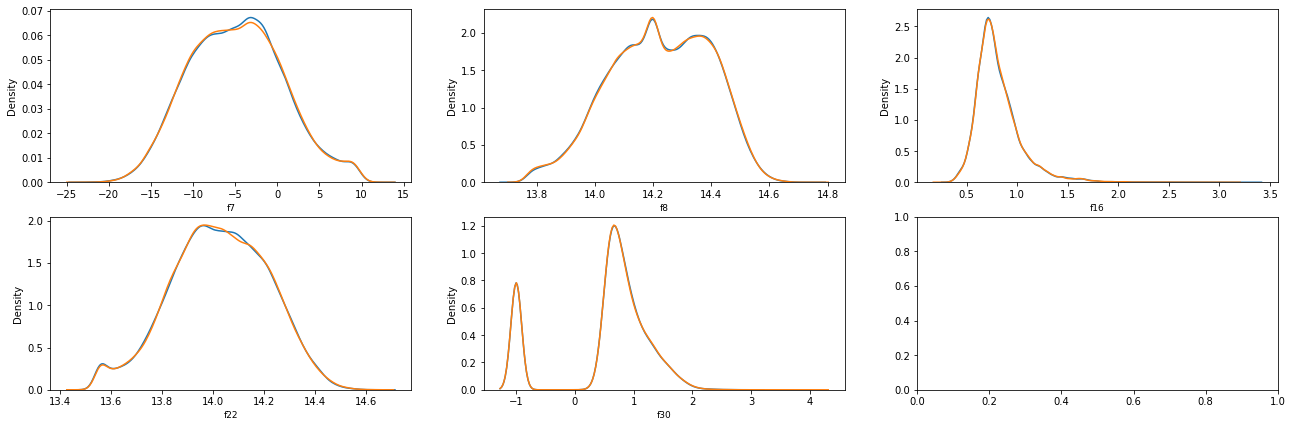

We see they are similar


In [107]:
print('Check out real values train/test')
num_cols = fetures_real
fig, ax = plt.subplots(2,3,figsize=(22,7))
for i, col in enumerate(num_cols):
    plt.subplot(2,3,i+1)
    plt.xlabel(col, fontsize=9)
    sns.kdeplot(train[col].values,label='Train')
    sns.kdeplot(test[col].values,label='Test')
   
plt.show() 
print('We see they are similar')

Real number columns, train targets vs test set


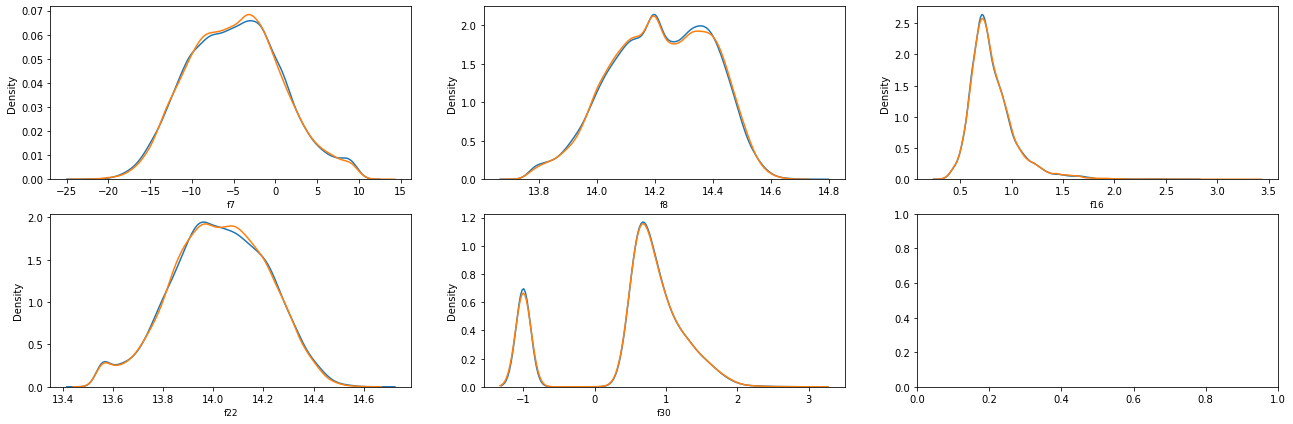

We see basically no difference between train targets


In [108]:
# look at real numbers columns
print('Real number columns, train targets')

target0 = train.loc[train['target'] == 0]
target1 = train.loc[train['target'] == 1]

fig, ax = plt.subplots(2,3,figsize=(22,7))
for i, col in enumerate(features_real):
    plt.subplot(2,3,i+1)
    plt.xlabel(col, fontsize=9)
    sns.kdeplot(target0[col].values, label='Target: 0')
    sns.kdeplot(target1[col].values, label='Target: 1')
    #sns.kdeplot(test[col].values, label='Test')

plt.show()
print('We see basically no difference between train targets')

<Figure size 1224x2520 with 0 Axes>

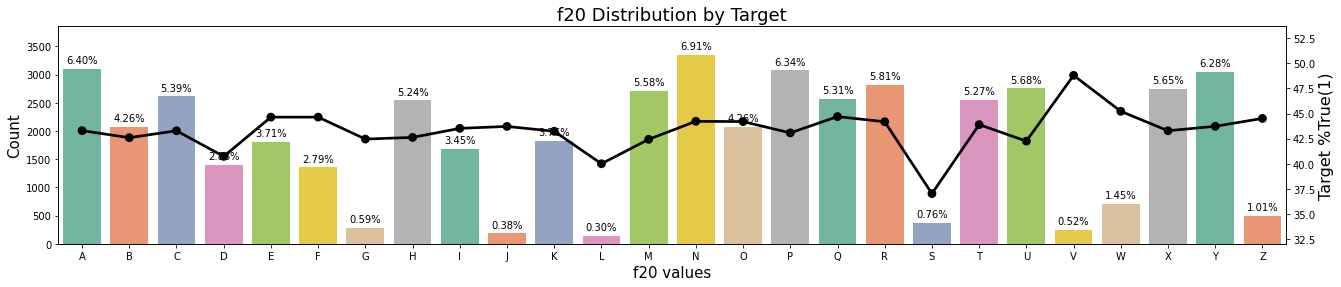

In [106]:
# creds: https://www.kaggle.com/warkingleo2000/first-step-on-kaggle
ord_cols = ['f20']
plt.figure(figsize=(17, 35)) 
fig, ax = plt.subplots(1,1,figsize=(22,10))

for i, col in enumerate(train[ord_cols]): 
    tmp = pd.crosstab(train[col], train['target'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

    ax = plt.subplot(2,1,i+1)
    sns.countplot(x=col, data=train, order=list(tmp[col].values) , palette='Set2') 
    ax.set_ylabel('Count', fontsize=15) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

    # twinX - to build a second yaxis
    gt = ax.twinx()
    gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
    gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
    gt.set_ylabel("Target %True(1)", fontsize=16)
    sizes=[] # Get highest values in y
    total = sum([p.get_height() for p in ax.patches])
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                    height + 100,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center") 
    ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


plt.subplots_adjust(hspace = 0.5, wspace=.3)
plt.show()

# Now explore train data (with known target)

Tageet distribution:


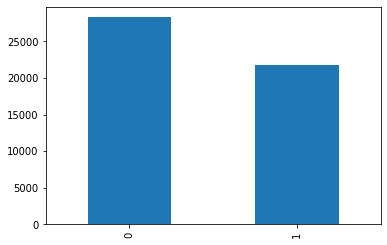

We see targets are not balanced


In [27]:
print('Tageet distribution:')
train['target'].value_counts().plot.bar()
plt.show()
print('We see targets are not balanced')

Show how the catergorical values are distributed per target


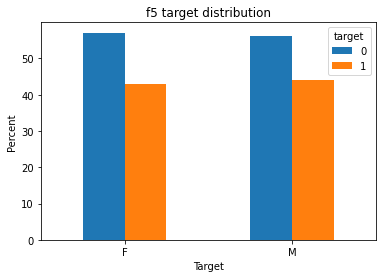

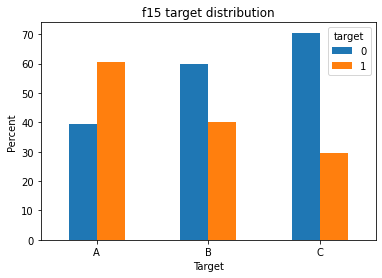

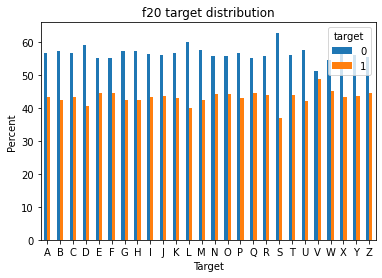

In [59]:
cat_columns = ['f5', 'f15', 'f20']

print('Show how the catergorical values are distributed per target')
for column in cat_columns:
    group = train.groupby([column, 'target'])
    percent = group.size().groupby(level=0).apply(lambda count: 100 * count / sum(count)).rename('Percent').reset_index()
    pivot = percent.pivot(column, 'target', 'Percent')

    ax = pivot.plot.bar(stacked=False, rot=0)
    plt.title(f'{column} target distribution')
    plt.ylabel('Percent')
    plt.xlabel('Target')
    plt.show()

In [68]:
# Out of curiosity we want to explore the rows with a 1 and a 0 separately
true_train = train.loc[train['target'] == 1]
false_train = train.loc[train['target'] == 0]


In [ ]:
#true_profile = pandas_profiling.ProfileReport(true_train_data, minimal=True).to_file('true_train_report.html')
#true_profile = pandas_profiling.ProfileReport(false_train_data, minimal=True).to_file('false_train_report.html')

By looking at the different in distribution of values within each column with respect to whether the target is a 0 or a 1
the interesting columns seem to be:
f0, f1, f2, f3, f4, f6, f13, f14(?) f15, f17, f18, f19, f21, f23, f24, f25, f26

f13: different distribution, and 0 class have a weird common interval. Feature could be age, since values are whole numbers. 
then negative values are noise, and should be removed. 

f15: (A, B, C column) is _very_ discriminating between 0 and 1. A is twice as often a 1 than C, and the opposite for 0. 
 B have equal distribution.
 
f18: Many '5' values are class 1. 